In [1]:
import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F
matplotlib.rcParams.update({'font.size': 16, "figure.autolayout": True})

In [2]:
def training(model, criterion, optim, X_train, X_test, y_train, y_test, n_epochs=100):    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    for it in range(n_epochs): 
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optim.zero_grad()
        loss.backward()
        optim.step()

        outputs_test = model(X_test)
        loss_test = criterion(outputs_test, y_test)

        train_losses[it] = loss.item()
        test_losses[it] = loss_test.item()

        if (it + 1) % 50 == 0:
            print(f'In this epoch {it+1}/{n_epochs}, Training loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

    return train_losses, test_losses

In [3]:
QSLIDES = "Data/GOOGLE SLIDES QUIC.csv"
QDOCS = "Data/GOOGLE DOCS QUIC.csv"
QSHEETS = "Data/GOOGLE SHEETS QUIC.csv"

TEST_SIZE = 0.1
GROUP = 10

In [4]:
qslides = preprocessing.grouped_nparray_from_file(QSLIDES, 0, GROUP)
qdocs = preprocessing.grouped_nparray_from_file(QDOCS, 1, GROUP)
qsheets = preprocessing.grouped_nparray_from_file(QSHEETS, 2, GROUP)

In [5]:
data = np.concatenate([qslides, qdocs, qsheets])

In [6]:
data.shape

(15035, 10, 36)

In [7]:
X = data[:,:,:-3]
y = data[:,0,-3:]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True)
X_train = torch.as_tensor(X_train, device="cuda")
X_test = torch.as_tensor(X_test, device="cuda")
y_train = torch.as_tensor(y_train, device="cuda")
y_test = torch.as_tensor(y_test, device="cuda")

In [9]:
# X_demo = torch.as_tensor(X).float()
# t1 = nn.Conv1d(in_channels=GROUP, out_channels=64, kernel_size=5, padding=2)(X_demo)
# t2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5, padding=2)(t1)
# t3 = nn.AvgPool1d(kernel_size=5, padding=2)(t2)
# t4 = nn.Flatten()(t3)
# t5 = nn.Linear(in_features=160, out_features=300)(t4)
# t6 = nn.Linear(in_features=300, out_features=90)(t5)
# t7 = nn.Linear(in_features=90, out_features=3)(t6)
# t8 = nn.Softmax(dim=1)(t7)
# print(t1.shape, t2.shape, t3.shape, t4.shape, t5.shape, t6.shape, t7.shape, t8.shape, sep="\n")

In [10]:
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv0 = nn.Conv1d(in_channels=GROUP, out_channels=16, kernel_size=3, padding=1, device="cuda")
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=4, kernel_size=3, padding=1, device="cuda")
        self.avg3 = nn.AvgPool1d(kernel_size=5, padding=2)
        self.flat4 = nn.Flatten()
        self.lin5 = nn.Linear(in_features=28, out_features=10, device="cuda")
        self.lin7 = nn.Linear(in_features=10, out_features=3, device="cuda")
        self.smax8 = nn.Softmax(dim=1)
        
    def forward(self, x):
        # x = self.bn1(x)
        x = F.leaky_relu(self.conv0(x), 0.1)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = self.avg3(x)
        x = self.flat4(x)
        x = self.lin5(x)
        x = self.lin7(x)
        x = self.smax8(x)
        return x

In [11]:
n = Network().to("cuda").double()
criterion = nn.MSELoss()
opt = optim.AdamW(n.parameters())

In this epoch 50/2000, Training loss: 0.2184, Test loss: 0.2179
In this epoch 100/2000, Training loss: 0.2148, Test loss: 0.2149
In this epoch 150/2000, Training loss: 0.2055, Test loss: 0.2068
In this epoch 200/2000, Training loss: 0.1957, Test loss: 0.1987
In this epoch 250/2000, Training loss: 0.1864, Test loss: 0.1903
In this epoch 300/2000, Training loss: 0.1788, Test loss: 0.1843
In this epoch 350/2000, Training loss: 0.1749, Test loss: 0.1813
In this epoch 400/2000, Training loss: 0.1723, Test loss: 0.1797
In this epoch 450/2000, Training loss: 0.1699, Test loss: 0.1779
In this epoch 500/2000, Training loss: 0.1677, Test loss: 0.1758
In this epoch 550/2000, Training loss: 0.1656, Test loss: 0.1741
In this epoch 600/2000, Training loss: 0.1640, Test loss: 0.1728
In this epoch 650/2000, Training loss: 0.1626, Test loss: 0.1715
In this epoch 700/2000, Training loss: 0.1615, Test loss: 0.1708
In this epoch 750/2000, Training loss: 0.1600, Test loss: 0.1694
In this epoch 800/2000, Tr

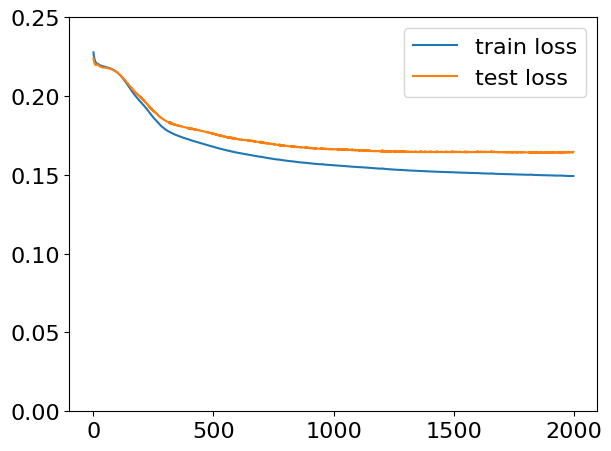

In [12]:
train_losses, test_losses = training(n, criterion, opt, X_train, X_test, y_train, y_test, 2000)

plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.ylim(0, 0.25)
plt.legend()
plt.savefig("quictrainingloss.png")

In [13]:
from sklearn.metrics import f1_score, multilabel_confusion_matrix

In [14]:
y_pred = n(X_test).detach().cpu().numpy()
y_onehot = np.zeros_like(y_pred)
y_onehot[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
y_real = y_test.detach().cpu().numpy()
f1 = f1_score(y_real, y_onehot, average="micro")
mlcm = multilabel_confusion_matrix(y_real.argmax(1), y_pred.argmax(1))

In [15]:
print(f1)
print(mlcm)

# TCP 0.6749467707594038
# QUIC 0.6349734042553191

0.6349734042553191
[[[846 156]
  [257 245]]

 [[852 171]
  [151 330]]

 [[761 222]
  [141 380]]]


In [16]:
import pandas as pd

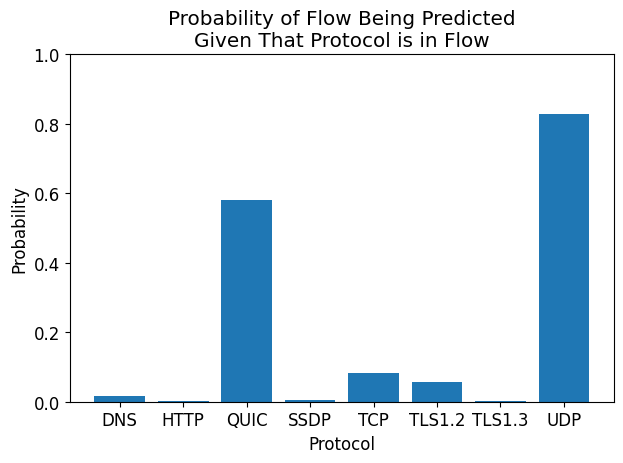

In [17]:
matplotlib.rcParams.update({'font.size': 12, "figure.autolayout": True})

protocols = ["DNS", "HTTP", "QUIC", "SSDP", "TCP", "TLS1.2", "TLS1.3", "UDP"]
in_flow = np.zeros_like(protocols, dtype=int)
correct_pred = 0

y_pred = n(X_test)
for i, y in enumerate(y_pred):
    if y.argmax() == y_test[i].argmax():
        correct_pred += 1
        z = X_test[i,:,GROUP:GROUP+len(protocols)].cpu().max(axis=0).values
        for j in range(len(z)):
            if z[j] == 1:
                in_flow[j] += 1
                
in_flow = in_flow / in_flow.sum()

conditional_prob = (in_flow * len(X_test)) / correct_pred

plt.bar(protocols, conditional_prob)
plt.ylim(0, 1)
plt.xlabel("Protocol")
plt.ylabel("Probability")
plt.title("Probability of Flow Being Predicted\nGiven That Protocol is in Flow")
plt.savefig("quicconditionalprob.png")

after = X_test.detach().cpu().numpy()[:,:,GROUP:GROUP+len(protocols)]
#print(after)